Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_C1_downsamp.tsv <br>
10005CN48_D1_downsamp.tsv <br>
10005CN48_E1_downsamp.tsv <br>
10015CN60_E2_downsamp.tsv <br>
10015CN84_C2_downsamp.tsv <br>
10015CN84_D2_downsamp.tsv <br>
10005CN48_C1_stdata_under_tissue_IDs.txt <br>
10005CN48_D1_stdata_under_tissue_IDs.txt <br>
10005CN48_E1_stdata_under_tissue_IDs.txt <br>
10015CN60_E2_stdata_under_tissue_IDs.txt <br>
10015CN84_C2_stdata_under_tissue_IDs.txt <br>
10015CN84_D2_stdata_under_tissue_IDs.txt<br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import matplotlib as mpl
import statistics
import statsmodels.api as sm
import matplotlib.patches as mpatches
import scipy.stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['index'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
        
    elif row['index'] in ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1']:
        return condition[1]

In [4]:
# Make a sample-condition dictionary
sam_cond = {'ST': ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1'],
           'sm-omics':['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']}



In [5]:
'Reads in tsv counts files'
path = '../../smomics_data/'

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']


files_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_downsamp_stdata.tsv'), sep = '\t', index_col=0)
    files_dict[filename] = file.T


In [6]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_stdata_under_tissue_IDs.txt'), sep = '\t', index_col=0)
    
    spot_coord = list()
    
    # 10005CN48_E1 samples have spot coordinates in float...
    if filename.startswith('10005CN48_E1'):
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)

    genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]

    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 
    print(k)
    print(len(v_under_tissue.columns))

    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

10005CN48_C1
279
10005CN48_D1
271
10005CN48_E1
203
10015CN84_D2
235
10015CN84_C2
267
10015CN60_E2
276


In [7]:
'Collects average gene and UMI counts inside vs. outside tissue in a dataframe'
# Filter on sequencing depth
seq_depth = {'10015CN84_D2':[23113376, 23],
            '10015CN60_E2':[33876251, 33],
            '10015CN84_C2':[28174220, 28],
            '10005CN48_C1':[71022006, 71],
            '10005CN48_D1':[75643539, 75],
            '10005CN48_E1': [58631758, 58]}

gene_dict = {}
umi_dict = {}
values_dict = {}
all_values = []
all_values_genes = []
total_counts_dict = {}
total_genes_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    print(key)
    for i, val in enumerate(value): # [inside/outside] of tissue  
    
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
            
        if i == 0: # inside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key] = [genes_per_spot]
            umi_dict[key] = [umis_per_spot]          
            
            # collect data for norm test
            values_dict[key] = [value_red.sum(axis = 0)]
            print(umis_per_spot)
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs inside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes inside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key] = [total_counts]
            total_genes_dict[key] = [total_genes]
            
        elif i == 1: # outside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key].append(genes_per_spot)
            umi_dict[key].append(umis_per_spot)

            # collect data for norm test
            values_dict[key].append(value_red.sum(axis = 0))
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs outside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes outside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key].append(total_counts)
            total_genes_dict[key].append(total_genes)

# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi = pd.DataFrame.from_dict(umi_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi['Condition'] = df_umi.apply(lambda row: condition(row), axis=1)
df_umi_total = pd.DataFrame.from_dict(total_counts_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi_total['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_genes_total = pd.DataFrame.from_dict(total_genes_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df_genes_total['Condition'] = df.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])
dfplot_umi = pd.melt(df_umi, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_umi_total = pd.melt(df_umi_total, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_genes_total = pd.melt(df_genes_total, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])

# collect data for checking distribution 
ls = pd.DataFrame.from_dict(values_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
ls['Condition'] = ls.apply(lambda row: condition(row), axis=1)
ls_melt = pd.melt(ls, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])

# collect all umis per spot
all_df_umi = pd.concat(all_values)
all_df_umi['Condition'] = all_df_umi.apply(lambda row: condition(row), axis=1)

# collect all genes per spot
all_df_genes = pd.concat(all_values_genes)
all_df_genes['Condition'] = all_df_genes.apply(lambda row: condition(row), axis=1)


10005CN48_C1
3540.3978494623657
10005CN48_D1
3423.752767527675
10005CN48_E1
2599.7093596059112
10015CN84_D2
10923.68085106383
10015CN84_C2
9175.258426966293
10015CN60_E2
13683.329710144928


st
variance: 0.2061626474886644
mean: 7.985857650038565
ks test p = 0.505861
The null hypothesis can be rejected. Data is normal.
smomics
variance: 0.45401740585015454
mean: 9.139024525840808
ks test p = 0.059861
The null hypothesis can be rejected. Data is normal.


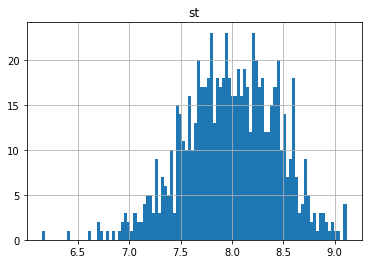

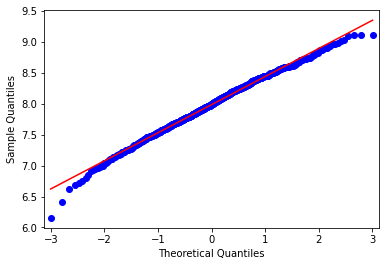

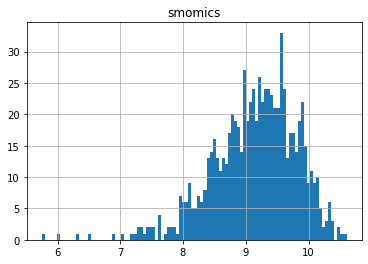

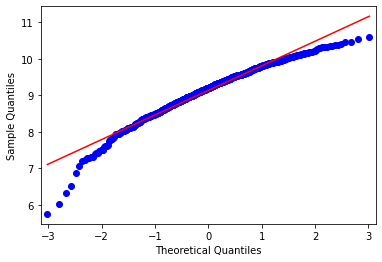

In [8]:
# Check for data distribution; if not normal - perform Wilcoxons later
#data collection and clean up 
ls_inside = ls_melt[ls_melt['variable'] == 'UMIs inside'].reset_index(drop=True)
ls = []
for i in ls_inside[ls_inside['Condition'] == 'ST']['value']:
    ls.append(i)
st = [item for sublist in ls for item in sublist]
ls = []
for i in ls_inside[ls_inside['Condition'] == 'sm-omics']['value']:
    ls.append(i)
smomics = [item for sublist in ls for item in sublist]
ls_inside = pd.DataFrame({'Condition':['st', 'smomics'], 'value':[st, smomics]})

#check with ks test
for i in ls_inside.index:
    
    # plot replicate visium umis
    a = np.log(ls_inside.iloc[i,:]['value'])
    a = a[~np.isinf(a)]
    #a = ls_inside.iloc[i,:]['value']
    #a = a[(a>a.mean()-3*a.std())&(a<a.mean()+3*a.std())]

    pd.DataFrame(a).hist(bins = 100)
    print(ls_inside.iloc[i,:]['Condition'])
    plt.title(ls_inside.iloc[i,:]['Condition'])
    print('variance: '+str(statistics.variance(a)))
    print('mean: '+str(np.mean(a)))
    # check for normal distribution 
    sm.qqplot(a, line='s')
    

    k2, p = scipy.stats.kstest(a, 'norm', args=(a.mean(), a.std()))#, 'norm', args=(a.mean(), a.std()))
    print("ks test p = {:g}".format(p))
    alpha = 0.001

    if p > alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected. Data is normal.")
    else:
        print("The null hypothesis cannot be rejected. Data is non-normal.")

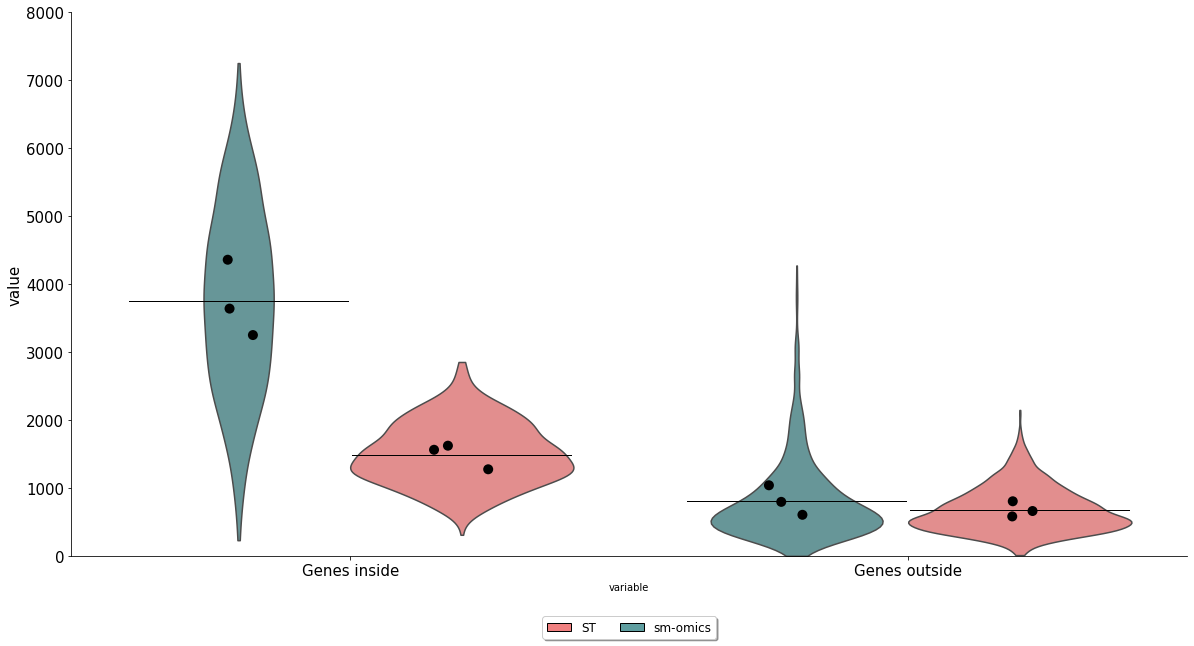

In [9]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot

ax = sns.stripplot(x=x, y=y, data=data,  hue=hue, dodge=True, hue_order = ['sm-omics', 'ST',], order = ['Genes inside', 'Genes outside'], palette = [ 'black','black',],size=10)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Genes per spot (mean)", fontsize=15)
ax.set_ylim([0,8000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('Genes inside','sm-omics'), ('Genes inside','visium')),
               (('Genes outside','sm-omics'), ('Genes outside','visium'))]

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=data,
            hue=hue,
            hue_order = ['sm-omics', 'ST',], 
            order = ['Genes inside', 'Genes outside'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

sns.violinplot(x=x, 
                    y=y, 
                    data=all_df_genes, 
                    hue=hue, 
                    hue_order = ['sm-omics', 'ST',], 
                    order = ['Genes inside', 'Genes outside'], 
                    palette = [ 'cadetblue','lightcoral',], 
                    cut=0,
                   inner = None)

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'ST',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Genes_Brain.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [10]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        Genes inside   1485.0
          Genes outside   681.0
sm-omics  Genes inside   3748.0
          Genes outside   812.0

In [11]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        Genes inside   185.0
          Genes outside  113.0
sm-omics  Genes inside   562.0
          Genes outside  218.0

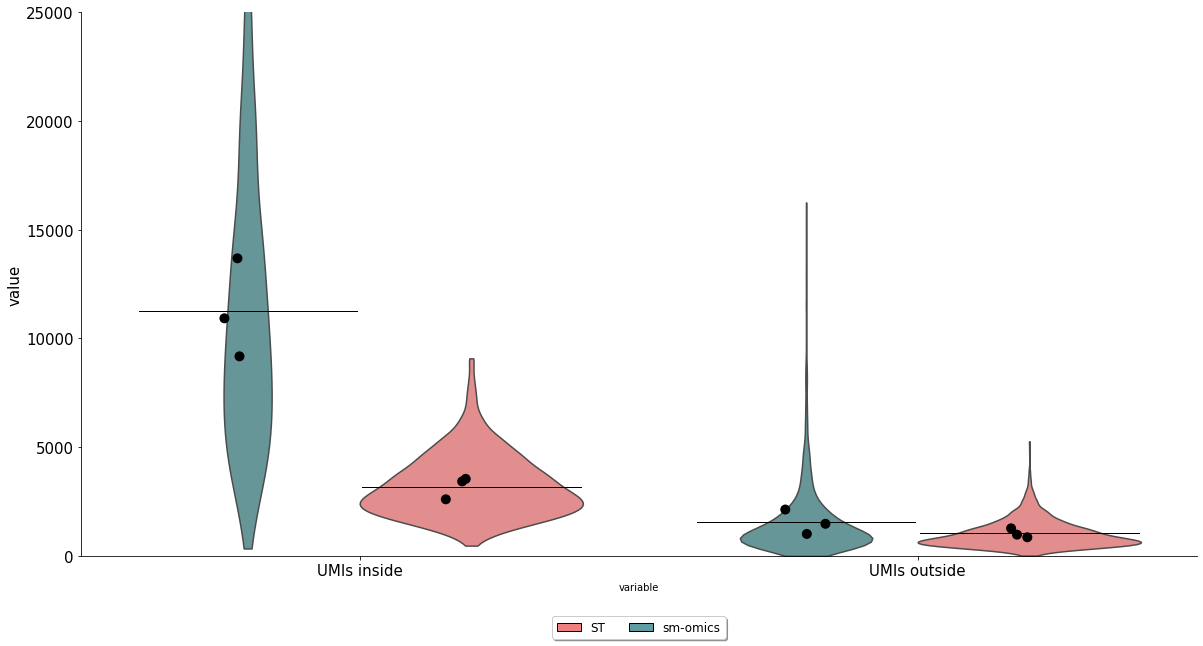

In [12]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot_umi

ax = sns.stripplot(x=x, y=y, data=data,  hue=hue, dodge=True, hue_order = ['sm-omics', 'ST',], order = ['UMIs inside', 'UMIs outside'], palette = [ 'black','black',],size=10)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("UMIs per spot (mean)", fontsize=15)
ax.set_ylim([0,25000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('UMIs inside','sm-omics'), ('UMIs inside','visium')),
               (('UMIs outside','sm-omics'), ('UMIs outside','visium'))]

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=data,
            hue=hue,
            hue_order = ['sm-omics', 'ST',], 
            order = ['UMIs inside', 'UMIs outside'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

sns.violinplot(x=x, 
                    y=y, 
                    data=all_df_umi, 
                    hue=hue, 
                    hue_order = ['sm-omics', 'ST',], 
                    order = ['UMIs inside', 'UMIs outside'], 
                    palette = [ 'cadetblue','lightcoral',], 
                    cut=0,
                   inner = None)

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'ST',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_UMIs_Brain.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [13]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        UMIs inside    3188.0
          UMIs outside   1031.0
sm-omics  UMIs inside   11261.0
          UMIs outside   1537.0

In [14]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        UMIs inside    513.0
          UMIs outside   211.0
sm-omics  UMIs inside   2273.0
          UMIs outside   563.0

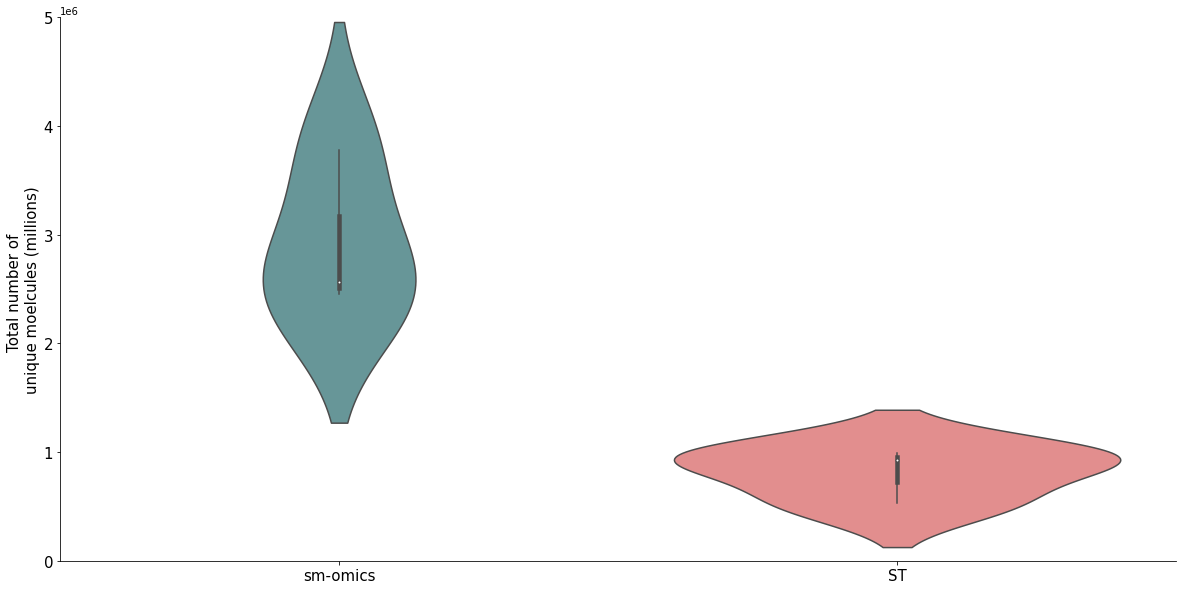

In [15]:
# Plot total UMI counts per condition
fig = plt.figure(figsize=(5, 5)) 

x='Condition'
y='value'
df_umi_total_inside = df_umi_total[df_umi_total['variable'] == "UMIs inside"]
data=df_umi_total_inside

ax = sns.violinplot(x=x, y=y, data=data, palette = ['cadetblue', 'lightcoral'], order = ['sm-omics', 'ST'])

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Total number of \nunique moelcules (millions)", fontsize=15)
ax.set_ylim([0,5000000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xticklabels(['sm-omics', 'ST'])

# # Separator on y axis
# ax.get_yaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(float(x/1000000), ',')))

# Calculate T-test 
boxPairList = [(('sm-omics'), ('ST'))]


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Total_UMIs.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [16]:
df_umi_total_inside

,index,Condition,variable,value
0,10005CN48_C1,ST,UMIs inside,987771.0
1,10005CN48_D1,ST,UMIs inside,927837.0
2,10005CN48_E1,ST,UMIs inside,527741.0
3,10015CN84_D2,sm-omics,UMIs inside,2567065.0
4,10015CN84_C2,sm-omics,UMIs inside,2449794.0
5,10015CN60_E2,sm-omics,UMIs inside,3776599.0


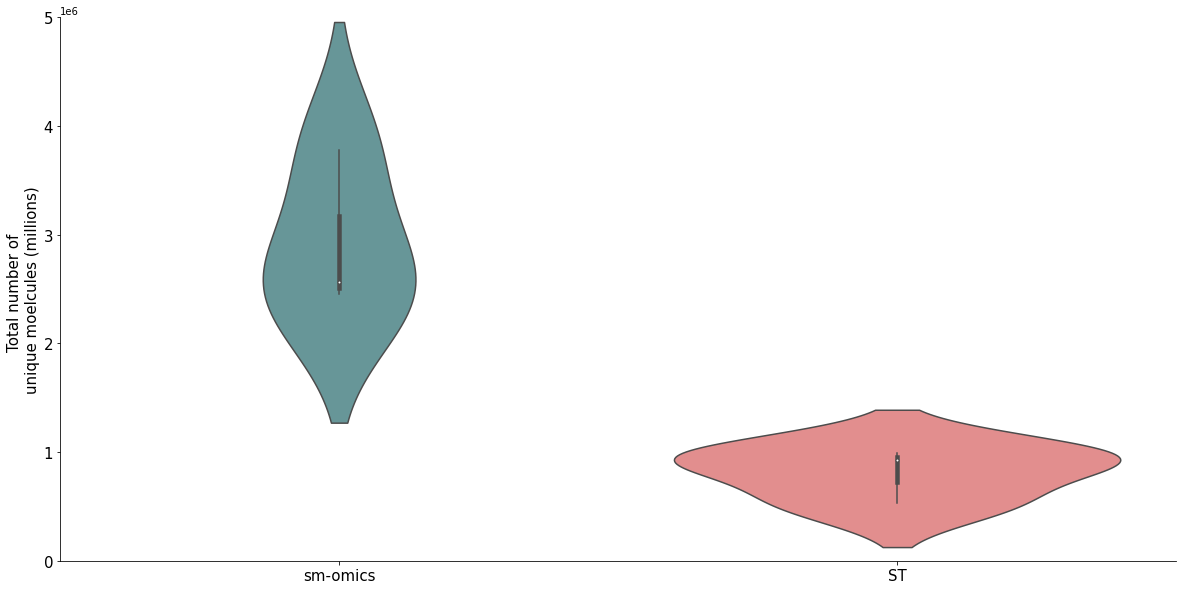

In [28]:
# Plot total UMI counts per condition
fig = plt.figure(figsize=(5, 5)) 

x='Condition'
y='value'
df_umi_total_inside = df_umi_total[df_umi_total['variable'] == "UMIs inside"]
data=df_umi_total_inside

ax = sns.violinplot(x=x, y=y, data=data, palette = ['cadetblue', 'lightcoral'], order = ['sm-omics', 'ST'])

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Total number of \nunique moelcules (millions)", fontsize=15)
ax.set_ylim([0,5000000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xticklabels(['sm-omics', 'ST'])

# # Separator on y axis
# ax.get_yaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(float(x/1000000), ',')))

# Calculate T-test 
boxPairList = [(('sm-omics'), ('ST'))]


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Total_UMIs.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

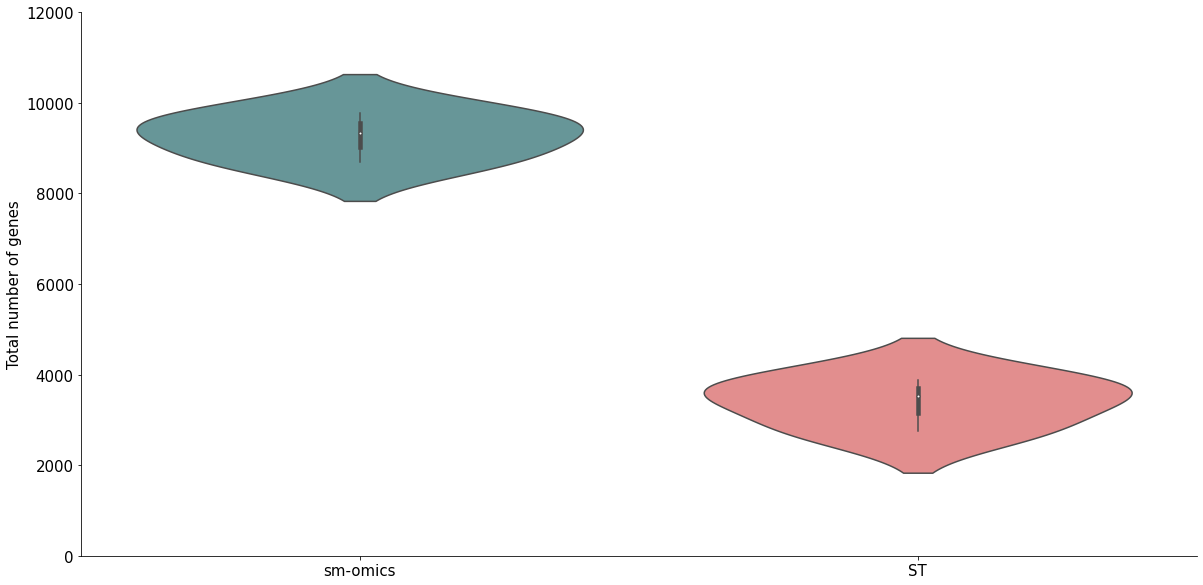

In [18]:
# Plot total genes per condition
fig = plt.figure(figsize=(5, 5)) 

x='Condition'
y='value'
df_genes_total_inside = df_genes_total[df_genes_total['variable'] == "Genes inside"]
data=df_genes_total_inside

ax = sns.violinplot(x=x, y=y, data=data, palette = ['cadetblue', 'lightcoral'], order = ['sm-omics', 'ST'])

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Total number of genes", fontsize=15)
ax.set_ylim([0,12000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xticklabels(['sm-omics', 'ST'])

# # Separator on y axis
# ax.get_yaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(float(x/1000000), ',')))

# Calculate T-test 
boxPairList = [(('sm-omics'), ('ST'))]

fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Total_Genes.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [19]:
df_umi_total_INSIDE = dfplot_umi[dfplot_umi['variable'] == 'UMIs inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,UMIs inside,3187.953326
sm-omics,UMIs inside,11260.756329


In [20]:
df_umi_total_INSIDE = dfplot_umi[dfplot_umi['variable'] == 'UMIs inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()

,,value
Condition,variable,
ST,UMIs inside,512.761876
sm-omics,UMIs inside,2272.859781


In [21]:
100*df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()/df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,UMIs inside,16.08436
sm-omics,UMIs inside,20.18390


In [22]:
df_umi_total_INSIDE = dfplot[dfplot['variable'] == 'Genes inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,Genes inside,1485.226480
sm-omics,Genes inside,3748.433324


In [23]:
df_umi_total_INSIDE = dfplot[dfplot['variable'] == 'Genes inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()

,,value
Condition,variable,
ST,Genes inside,185.476849
sm-omics,Genes inside,562.411129


In [24]:
100*df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()/df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,Genes inside,12.488119
sm-omics,Genes inside,15.003898
